In [38]:
import pandas as pd
import os

import scipy.stats as stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler



import matplotlib as plt
import seaborn as sns
import numpy as np


from env import get_db_url

### 1. Acquire data from the cloud database.

You will want to end with a single dataframe. Include the logerror field and all other fields related to the properties that are available. You will end up using all the tables in the database.

Be sure to do the correct join (inner, outer, etc.). We do not want to eliminate properties purely because they may have a null value for airconditioningtypeid. - Only include properties with a transaction in 2017, and include only the last transaction for each property (so no duplicate property ID's), along with zestimate error and date of transaction. (Hint: read the docs for the .duplicated method) - Only include properties that have a latitude and longitude value.

In [2]:
sql = """SELECT
  *
FROM properties_2017
LEFT JOIN predictions_2017 AS pe USING (parcelid)
LEFT JOIN architecturalstyletype AS arch USING (architecturalstyletypeid)
LEFT JOIN propertylandusetype USING (propertylandusetypeid)
LEFT JOIN airconditioningtype USING (airconditioningtypeid)
LEFT JOIN typeconstructiontype USING (typeconstructiontypeid)
LEFT JOIN storytype USING (storytypeid)
LEFT JOIN unique_properties USING (parcelid)
LEFT JOIN heatingorsystemtype USING (heatingorsystemtypeid)
WHERE propertylandusetype.propertylandusedesc = 'Single Family Residential'
AND pe.transactiondate LIKE '2017%%';
    
    """

df = pd.read_sql(sql, get_db_url("zillow"));

Summarize your data (summary stats, info, dtypes, shape, distributions, value_counts, etc.)

In [3]:
df.columns

Index(['heatingorsystemtypeid', 'parcelid', 'storytypeid',
       'typeconstructiontypeid', 'airconditioningtypeid',
       'propertylandusetypeid', 'architecturalstyletypeid', 'id',
       'basementsqft', 'bathroomcnt', 'bedroomcnt', 'buildingclasstypeid',
       'buildingqualitytypeid', 'calculatedbathnbr', 'decktypeid',
       'finishedfloor1squarefeet', 'calculatedfinishedsquarefeet',
       'finishedsquarefeet12', 'finishedsquarefeet13', 'finishedsquarefeet15',
       'finishedsquarefeet50', 'finishedsquarefeet6', 'fips', 'fireplacecnt',
       'fullbathcnt', 'garagecarcnt', 'garagetotalsqft', 'hashottuborspa',
       'latitude', 'longitude', 'lotsizesquarefeet', 'poolcnt', 'poolsizesum',
       'pooltypeid10', 'pooltypeid2', 'pooltypeid7',
       'propertycountylandusecode', 'propertyzoningdesc',
       'rawcensustractandblock', 'regionidcity', 'regionidcounty',
       'regionidneighborhood', 'regionidzip', 'roomcnt', 'threequarterbathnbr',
       'unitcnt', 'yardbuildingsqft17',

In [4]:
df.parcelid.value_counts()

11991059    3
11957553    2
12478591    2
12035592    2
12443331    2
           ..
11494547    1
10976762    1
12650619    1
12650850    1
12826780    1
Name: parcelid, Length: 52320, dtype: int64

In [5]:
df.shape

(52441, 68)

In [6]:
df.head(5)

,heatingorsystemtypeid,parcelid,storytypeid,typeconstructiontypeid,airconditioningtypeid,propertylandusetypeid,architecturalstyletypeid,id,basementsqft,bathroomcnt,...,censustractandblock,id,logerror,transactiondate,architecturalstyledesc,propertylandusedesc,airconditioningdesc,typeconstructiondesc,storydesc,heatingorsystemdesc
0,NaN,14297519,NaN,NaN,NaN,261.0,NaN,1727539,NaN,3.5,...,6.059063e+13,0,0.025595,2017-01-01,None,Single Family Residential,None,None,None,None
1,NaN,17052889,NaN,NaN,NaN,261.0,NaN,1387261,NaN,1.0,...,6.111001e+13,1,0.055619,2017-01-01,None,Single Family Residential,None,None,None,None
2,NaN,14186244,NaN,NaN,NaN,261.0,NaN,11677,NaN,2.0,...,6.059022e+13,2,0.005383,2017-01-01,None,Single Family Residential,None,None,None,None
3,2.0,12177905,NaN,NaN,NaN,261.0,NaN,2288172,NaN,3.0,...,6.037300e+13,3,-0.103410,2017-01-01,None,Single Family Residential,None,None,None,Central
4,2.0,12095076,NaN,NaN,1.0,261.0,NaN,781532,NaN,3.0,...,6.037461e+13,6,-0.001011,2017-01-01,None,Single Family Residential,Central,None,None,Central


3. Write a function that takes in a dataframe of observations and attributes and returns a dataframe where each row is an atttribute name, the first column is the number of rows with missing values for that attribute, and the second column is percent of total rows that have missing values for that attribute. Run the function and document takeaways from this on how you want to handle missing values.

In [7]:
#checking for nulls
df.isnull().sum()

heatingorsystemtypeid     18506
parcelid                      0
storytypeid               52394
typeconstructiontypeid    52365
airconditioningtypeid     38803
                          ...  
propertylandusedesc           0
airconditioningdesc       38803
typeconstructiondesc      52365
storydesc                 52394
heatingorsystemdesc       18506
Length: 68, dtype: int64

In [8]:
#turning dataset horizontally for easier reading and making a copy for a new df that will show nulls count and % of nulls
df_nulls = df.copy().T

df.head()

,heatingorsystemtypeid,parcelid,storytypeid,typeconstructiontypeid,airconditioningtypeid,propertylandusetypeid,architecturalstyletypeid,id,basementsqft,bathroomcnt,...,censustractandblock,id,logerror,transactiondate,architecturalstyledesc,propertylandusedesc,airconditioningdesc,typeconstructiondesc,storydesc,heatingorsystemdesc
0,NaN,14297519,NaN,NaN,NaN,261.0,NaN,1727539,NaN,3.5,...,6.059063e+13,0,0.025595,2017-01-01,None,Single Family Residential,None,None,None,None
1,NaN,17052889,NaN,NaN,NaN,261.0,NaN,1387261,NaN,1.0,...,6.111001e+13,1,0.055619,2017-01-01,None,Single Family Residential,None,None,None,None
2,NaN,14186244,NaN,NaN,NaN,261.0,NaN,11677,NaN,2.0,...,6.059022e+13,2,0.005383,2017-01-01,None,Single Family Residential,None,None,None,None
3,2.0,12177905,NaN,NaN,NaN,261.0,NaN,2288172,NaN,3.0,...,6.037300e+13,3,-0.103410,2017-01-01,None,Single Family Residential,None,None,None,Central
4,2.0,12095076,NaN,NaN,1.0,261.0,NaN,781532,NaN,3.0,...,6.037461e+13,6,-0.001011,2017-01-01,None,Single Family Residential,Central,None,None,Central


In [9]:
#creating a column that counts all the nulls
df_nulls['num_rows_missing']= df_nulls.count(axis=1)

In [10]:
#creating a column that finds what % the nulls are based on dataset count
df_nulls['pct_rows_missing']= round(df_nulls.count(axis=1)* 100 / len(df_nulls))

In [11]:
df_nulls.head(10)

,0,1,2,3,4,5,6,7,8,9,...,52433,52434,52435,52436,52437,52438,52439,52440,num_rows_missing,pct_rows_missing
heatingorsystemtypeid,NaN,NaN,NaN,2.0,2.0,NaN,2.0,2.0,NaN,NaN,...,NaN,2.0,2.0,2.0,2.0,NaN,2.0,2.0,33935,49906.0
parcelid,14297519,17052889,14186244,12177905,12095076,12069064,12790562,11104527,13944538,17110996,...,12055795,12892446,10722691,12412492,11000655,17239384,12773139,12826780,52441,77121.0
storytypeid,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,47,71.0
typeconstructiontypeid,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,76,113.0
airconditioningtypeid,NaN,NaN,NaN,NaN,1.0,NaN,NaN,1.0,13.0,NaN,...,NaN,NaN,1.0,NaN,NaN,NaN,1.0,NaN,13638,20057.0
propertylandusetypeid,261.0,261.0,261.0,261.0,261.0,261.0,261.0,261.0,261.0,261.0,...,261.0,261.0,261.0,261.0,261.0,261.0,261.0,261.0,52441,77121.0
architecturalstyletypeid,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,70,104.0
id,1727539,1387261,11677,2288172,781532,870991,1246926,1639362,249412,43675,...,80446,1635173,1373391,2274245,673515,2968375,1843709,1187175,52441,77121.0
basementsqft,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,47,71.0
bathroomcnt,3.5,1.0,2.0,3.0,3.0,1.0,3.0,3.0,2.5,2.5,...,1.0,3.0,2.0,2.0,2.0,2.0,1.0,2.0,52441,77121.0


In [12]:
#Creating the function that applies these two columns above:

def missing_values():
    #creating a column that counts all the nulls
    df_nulls['num_rows_missing']= df_nulls.count(axis=1)
    #creating a column that finds what % the nulls are based on dataset count
    df_nulls['pct_rows_missing']= round(df_nulls.count(axis=1)* 100 / len(df_nulls))
    
    return df_nulls

## Prepare

1. Remove any properties that are likely to be something other than single unit properties. (e.g. no duplexes, no land/lot, ...). There are multiple ways to estimate that a property is a single unit, and there is not a single "right" answer.

In [13]:
#already brought in single family units
df.propertylandusedesc.unique()

array(['Single Family Residential'], dtype=object)

Create a function that will drop rows or columns based on the percent of values that are missing: handle_missing_values(df, prop_required_column, prop_required_row).

The input:
A dataframe
A number between 0 and 1 that represents the proportion, for each column, of rows with non-missing values required to keep the column. i.e. if prop_required_column = .6, then you are requiring a column to have at least 60% of values not-NA (no more than 40% missing).
A number between 0 and 1 that represents the proportion, for each row, of columns/variables with non-missing values required to keep the row. For example, if prop_required_row = .75, then you are requiring a row to have at least 75% of variables with a non-missing value (no more that 25% missing).
The output:
The dataframe with the columns and rows dropped as indicated. Be sure to drop the columns prior to the rows in your function.
hint:
Look up the dropna documentation.
You will want to compute a threshold from your input values (prop_required) and total number of rows or columns.

In [14]:
def handle_missing_values(df, prop_required_column = .67, prop_required_row = .75):
    threshold = int(round(prop_required_column*len(df.index),0))
    df.dropna(axis=1, thresh=threshold, inplace=True)
    threshold = int(round(prop_required_row*len(df.columns),0))
    df.dropna(axis=0, thresh=threshold, inplace=True)
    return df

In [15]:
zillow = handle_missing_values(df)
zillow.shape

(52439, 30)

## Mall Customers

1. Acquire data from the customers table in the mall_customers database.

In [17]:
query = '''
SELECT * 
FROM customers;
'''
url = get_db_url('mall_customers')
df = pd.read_sql(query, url)

In [18]:
df.head()

,customer_id,gender,age,annual_income,spending_score
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


2. Summarize the data (include distributions and descriptive statistics).


In [19]:
df.info

<bound method DataFrame.info of      customer_id  gender  age  annual_income  spending_score
0              1    Male   19             15              39
1              2    Male   21             15              81
2              3  Female   20             16               6
3              4  Female   23             16              77
4              5  Female   31             17              40
..           ...     ...  ...            ...             ...
195          196  Female   35            120              79
196          197  Female   45            126              28
197          198    Male   32            126              74
198          199    Male   32            137              18
199          200    Male   30            137              83

[200 rows x 5 columns]>

In [20]:
df.describe

<bound method NDFrame.describe of      customer_id  gender  age  annual_income  spending_score
0              1    Male   19             15              39
1              2    Male   21             15              81
2              3  Female   20             16               6
3              4  Female   23             16              77
4              5  Female   31             17              40
..           ...     ...  ...            ...             ...
195          196  Female   35            120              79
196          197  Female   45            126              28
197          198    Male   32            126              74
198          199    Male   32            137              18
199          200    Male   30            137              83

[200 rows x 5 columns]>

<AxesSubplot:xlabel='age', ylabel='Count'>

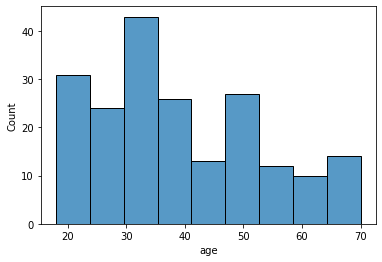

In [21]:
sns.histplot(df.age)

<AxesSubplot:xlabel='annual_income', ylabel='Count'>

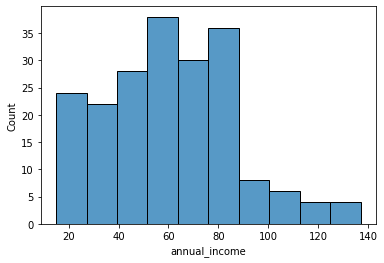

In [22]:
sns.histplot(df.annual_income)

<AxesSubplot:xlabel='spending_score', ylabel='Count'>

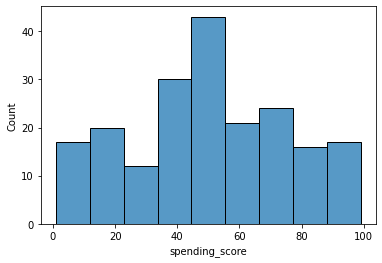

In [23]:
sns.histplot(df.spending_score)

3. Detect outliers using IQR.


In [25]:
q1, q3 = df.age.quantile([.25, .75])
iqr = q3 - q1
upper_bound = q3 + (1.5 * iqr)

lower_bound = q1 - (1.5 * iqr)

upper_bound, lower_bound

(79.375, -1.625)

In [26]:
df.age.max()

70

No age outliers.

In [27]:
q1, q3 = df.annual_income.quantile([.25, .75])
iqr = q3 - q1
upper_bound = q3 + (1.5 * iqr)

lower_bound = q1 - (1.5 * iqr)

upper_bound, lower_bound

(132.75, -13.25)

In [28]:
df['income_outlier'] = df.annual_income > upper_bound

In [29]:
df.head()

,customer_id,gender,age,annual_income,spending_score,income_outlier
0,1,Male,19,15,39,False
1,2,Male,21,15,81,False
2,3,Female,20,16,6,False
3,4,Female,23,16,77,False
4,5,Female,31,17,40,False


In [30]:
q1, q3 = df.spending_score.quantile([.25, .75])
iqr = q3 - q1
upper_bound = q3 + (1.5 * iqr)

lower_bound = q1 - (1.5 * iqr)

upper_bound, lower_bound

(130.375, -22.625)

In [31]:
df.spending_score.max()

99

No spending score outliers,

4. Split data into train, validate, and test.


In [33]:
train, test = train_test_split(df, test_size=.2)
train, validate = train_test_split(train, test_size = .3)

In [34]:
train.shape, validate.shape, test.shape

((112, 6), (48, 6), (40, 6))

5. Encode categorical columns using a one hot encoder (pd.get_dummies).

In [35]:
dummy_df = pd.get_dummies(df, columns = ['gender'], drop_first=True, dummy_na=False)
dummy_df.head()

,customer_id,age,annual_income,spending_score,income_outlier,gender_Male
0,1,19,15,39,False,1
1,2,21,15,81,False,1
2,3,20,16,6,False,0
3,4,23,16,77,False,0
4,5,31,17,40,False,0


6. Handles missing values.

In [37]:
df.isna().value_counts()

customer_id  gender  age    annual_income  spending_score  income_outlier
False        False   False  False          False           False             200
dtype: int64

There are no missing values.

7. Scaling

In [39]:
columns_to_scale = dummy_df.select_dtypes('number').columns.tolist()

In [42]:
columns_to_scale

scaler = MinMaxScaler()
scaled_df = dummy_df.copy()

In [43]:
scaled_df[columns_to_scale] = pd.DataFrame(scaler.fit_transform(dummy_df[columns_to_scale]),
                                          columns=columns_to_scale).set_index([dummy_df.index])

In [44]:
scaled_df

,customer_id,age,annual_income,spending_score,income_outlier,gender_Male
0,0.000000,0.019231,0.000000,0.387755,False,1.0
1,0.005025,0.057692,0.000000,0.816327,False,1.0
2,0.010050,0.038462,0.008197,0.051020,False,0.0
3,0.015075,0.096154,0.008197,0.775510,False,0.0
4,0.020101,0.250000,0.016393,0.397959,False,0.0
...,...,...,...,...,...,...
195,0.979899,0.326923,0.860656,0.795918,False,0.0
196,0.984925,0.519231,0.909836,0.275510,False,0.0
197,0.989950,0.269231,0.909836,0.744898,False,1.0
198,0.994975,0.269231,1.000000,0.173469,True,1.0
